<a href="https://colab.research.google.com/github/brianross93/anewnotebookfords/blob/main/BR_Image_Segmentation_for_Puppies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
---

# ✨ **CHALLENGE**: Performing Image Segmentation (with Puppies) ✨

In this challenge notebook, you'll apply what you've learned regarding object detection and image segmentation in order to utilize an advanced deep learning model for complex image learning.

More specifically, we'll be using a **modified U-Net** with an advanced architecture, comprising a higher-order series of upsampling and downsampling CNNs (represented by a decoder and encoder, respectively). 

Our encoder/downsampler of choice will be a **`MobileNetV2`**, while our decoder/upsampler of choice will be the original upsampling block of the original U-Net architecture. 

The goal will be to ultimately have your own example of a successfully functional image segmentation algorithm that can perform interestingly effectively against higher-order image data (albeit at a high computational expense). 

---
---

## 💠 **PART ONE**: Importations and Initializations 💠

Like always, we must start by importing relevant data structures, objects, and libraries needed to perform image processing, segmentation, and analysis. 

Two of the Tensorflow-related utility libraries we'll make use of today mandate external dependency management, which we'll set up with some immediate Bash scripting calls using `pip`. 

In [1]:
# Install Required TensorFlow Accessory Dependencies
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-fud_0aix
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-fud_0aix
  Created wheel for tensorflow-examples: filename=tensorflow_examples-86e95a594ffd7a74016a2b15991d2294725d7e28_-py3-none-any.whl size=268420 sha256=f577c4f276a6b875dc3094710b331d2b42c0d8d20638395c4c88a481a46b87d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-2p1nf3pr/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


After successfully calling our external dependencies into our notebook, we should be ready to go in terms of importing all relevant libraries for action! 

Today, we'll more precisely utilize Tensorflow and MatPlotLib pretty exhaustively. 

In [2]:
# Data Visualization and Plotting Utilities
import matplotlib.pyplot as plt

# TensorFlow Core and Accessory Utilities
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

# Interactive Python Display Configurations
from IPython.display import clear_output

---
---

## 💠 **PART TWO**: Custom Data Structure Setup 💠

Up front, we'll also identify all manners of helper functions and custom data structures before calling them throughout our data science project.

Since image segmentation often involves a pretty exhaustive amount of data preprocessing, augmentation, and sanitization in addition to model setup and engineering, we can expect this step to be fairly involved.

---

### 📌 **REQUIRED CHALLENGE!** 📌

> It's common to utilize custom data structures and modules to accelerate the data design process - especially at this stage of advanced-level modeling - but the more custom tools we use, the more we run the risk of confounding our development process.
> 
> This risk is especially so if we don't clearly document and explain what each of our custom utilities is actually doing.
> 
> **Your challenge is to closely examine and add relevant comments to each of the custom data structures and functions so as to improve your and others' understanding of what the data structure/function is actually doing.**
> 
> It's highly recommended that you come back to this challenge after you've progressed through the entire notebook at least once so that you have a better overall picture of what's going on.

---

Firstly, we'll create a custom function **`image_normalizer()`** to _normalize_ our images and reduce their dimensionalities.

In [3]:
def image_normalizer(input_image, input_mask):
  """ Custom function to normalize input image data. """
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

Next, we'll create an image-loading utility function **`image_loader()`** to assist us with extracting both image vector data and segmentation mask class data from our image objects.

In [4]:
def image_loader(image):
  """ Custom function to load in images and separate image vectors from segmentation masks. """
  input_image = tf.image.resize(image["image"], (128, 128))
  input_mask = tf.image.resize(image["segmentation_mask"], (128, 128))
  input_image, input_mask = image_normalizer(input_image, input_mask)
  return input_image, input_mask

Then, we'll create a helper class called **`ImageAugmenter()`** that will allow us to perform some basic image augmentation processing across input training image data.

In [5]:
class ImageAugmenter(tf.keras.layers.Layer):
  """ Custom class to apply image augmentations to input training image data. """
  def __init__(self, seed=42):
    """ Initialization method. """
    super().__init__()
    # Both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  def call(self, inputs, labels):
    """ Main class call method. """
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Now, we'll create a **`state_displayer()`** function to assist with displaying `matplotlib`-powered segmentation mask outputs per training epoch.

In [6]:
def state_displayer(display_list):
  """ Custom function to display current segmentation mask application per epoch. """
  plt.figure(figsize=(15, 15))
  titles = ["Input Image", "True Mask", "Predicted Mask"]
  for iterator in range(len(display_list)):
    plt.subplot(1, len(display_list), iterator + 1)
    plt.title(titles[iterator])
    plt.imshow(tf.keras.utils.array_to_img(display_list[iterator]))
    plt.axis("off")
  plt.show()

Next, we'll create the scaffolding for our U-Net model via the function **`network_instantiator()`**. 

In [7]:
def network_instantiator(output_channels: int, downstack, upstack):
  """ Custom function to instantiate U-Net network model for segmentation modeling. """
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  # Downsampling through the model.
  skips = downstack(inputs)
  outputs = skips[-1]
  skips = reversed(skips[:-1])
  # Upsampling and establishing the skip connections.
  for up, skip in zip(upstack, skips):
    outputs = up(outputs)
    concat = tf.keras.layers.Concatenate()
    outputs = concat([outputs, skip])
  # Final layer.
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding="same")  #64x64 -> 128x128
  outputs = last(outputs)
  return tf.keras.Model(inputs=inputs, outputs=outputs)

We'll also creating our image masking function **`masker()`** in order to produce the image segmentation masks using the predicted labels.

In [8]:
def masker(pred_mask):
  """ Custom function to render image segmentation masks as image. """
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

Additionally, we'll create a function called **`segmentation_visualizer()`** that combines other utility functions to display learned vs. true image segmentation masks pre- and post-training.

In [9]:
def segmentation_visualizer(dataset=None, num=1):
  """ Custom function to display predictive state of learned segmentation masking algorithm alongside true masks. """
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      state_displayer([image[0], mask[0], masker(pred_mask)])
  else:
    state_displayer([sample_image, sample_mask, 
                     masker(model.predict(sample_image[tf.newaxis, ...]))])

Finally, we'll also create a callback object called **`DisplayerCallback()`** that assists with displaying image segmentation visualization states after set training intervals.

In [10]:
class DisplayerCallback(tf.keras.callbacks.Callback):
  """ Custom class to visualize image segmentation learning state after every two epochs. """
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True); segmentation_visualizer()
    print ("\nSample Prediction after epoch {}\n".format(epoch+1))

Now that we're finally done with all of our necessary data structure configurations, we can finally jump into preprocessing and preparing our data for modeling and segmentation.

---
---

## 💠 **PART THREE**: Data Exploration and Visualization 💠

Our dataset of choice is a _puppy images dataset_, which we can access and download conditionally using the `tensorflow_datasets` external library. 

All it takes is one line of code. (Though we'll make it two for readability's sake!)

In [11]:
# Set Dataset Pathway (Non-Local Relative Link)
PATH_DATASET = str("oxford_iiit_pet:3.*.*")

# Read Image Dataset with Metadata
dataset, info = tfds.load(PATH_DATASET, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIOKZWV/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIOKZWV/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


We can also set some global training parameters since these are unlikely to change throughout our training process (and even if they do, we'll likely restart the entire pipeline upon those changes so we can initialize them from the top).

In [12]:
# Initialize Training Image Dataset Length
TRAIN_LENGTH = info.splits["train"].num_examples

# Set Image Batch and Buffer Sizes
BATCH_SIZE, BUFFER_SIZE = 64, 1000

# Instantiate Steps-Per-Epoch for Proceduralizing Modeling
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

Even though this is still data exploration and visualization, we do want to set our training and testing data up front so we can perform the appropriate augmentation-based preprocessing techniques as early as possible.

In [13]:
# Set Up Training Image Dataset
train_images = dataset["train"].map(image_loader, 
                                    num_parallel_calls=tf.data.AUTOTUNE)

# Set Up Testing Image Dataset
test_images = dataset["test"].map(image_loader, 
                                  num_parallel_calls=tf.data.AUTOTUNE)

Through method chaining, we can perform a myriad of transformations, augmentations, and imputations to our training data without majorly affecting our testing data.

In [14]:
# Configure Training Data Batches with Custom Data Transformations/Augmentations
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(ImageAugmenter())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# Configure Testing Data Batches
test_batches = test_images.batch(BATCH_SIZE)

Now that our image data is prepared and generated successfully, we can take a peak at it using some data visualization. 

Let's sample from our image dataset and render the images alongside their provided/true segmentation masks. 

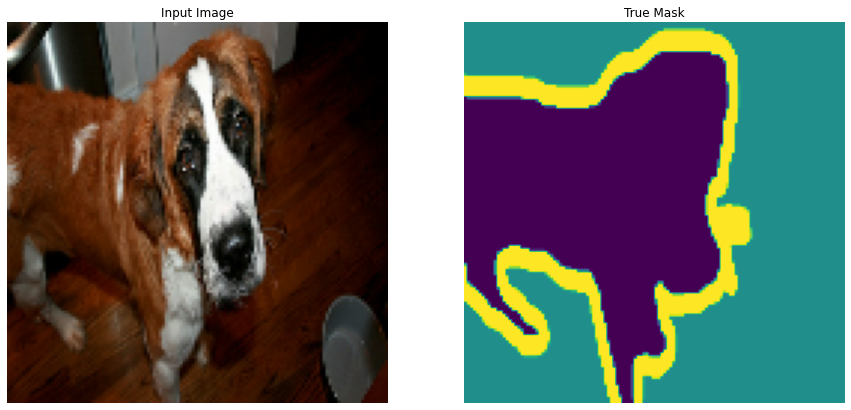

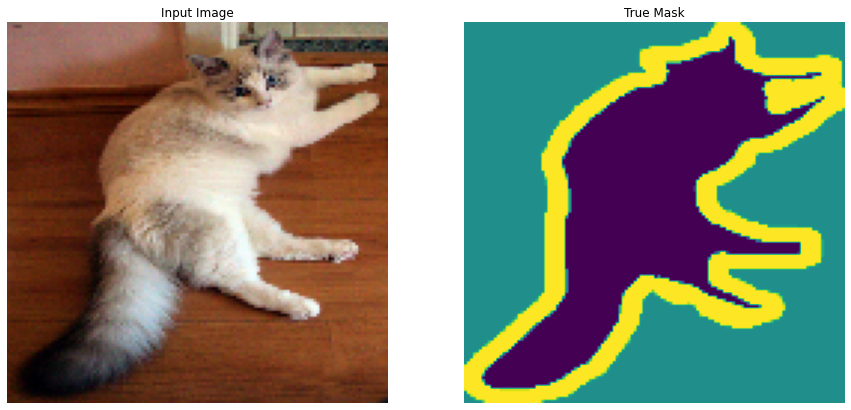

In [15]:
# Sample Images and Display Alongside True Segmentation Masks
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  state_displayer([sample_image, sample_mask])

Our data looks great! It's clear what our dataset images are as well as how our image segmentation masks map effectively to the objects we're aiming to identify in this task.

---

### 📌 **REQUIRED CHALLENGE!** 📌

> Take a moment to reflect on the quality and state of image data that we have access to. 
> 
> Having performed several image classification and learning tasks before, are you comfortable with the number of training/testing images we have with respect to the images' high dimensionality? 
> 
> Why or why not?
> 
> **Your challenge is to write an answer below to the aforementioned question regarding whether we have an appropriate quantity/distribution of images for this task.**
> 
> Ensure you take relevant factors into account, such as the type of model we'll be using, the dimensionality and preprocessing performed on the data, and the environment we're making use of to perform our learning task. 

---

Now let's move on to the step we've been waiting for: modeling our images and developing segmentation masks via deep learning.

---
---

## 💠 **PART FOUR**: Data Modeling and Image Segmentation 💠

Before we dive headfirst into developing and applying our modified U-Net, are we sure we fully understand what we're dealing with? 

---

### 📌 **REQUIRED CHALLENGE!** 📌

> Classically, we've attained the habit of evaluating machine learning and deep learning algorithms on a need-to-know basis; only disseminating them when we can make sense of what the algorithm explicitly does and how it functions.
> 
> However, in the realm of artificial intelligence, it can often be _very challenging_ to interpret what exactly a specific algorithm is doing simply by examining how it fares against a dataset or what accuracy score it obtains.
> 
> As such, we must start putting in some research work ahead of time to understand what higher-order machine algorithms we're making use of _before_ we apply them, through the ingestion of relevant papers and/or articles.
> 
> **Your challenge is to read/skim through the [relevant Papers With Code report on the `MobileNetV2` architecture](https://paperswithcode.com/method/mobilenetv2) and summarize what the algorithm is, how it performs, and a brief breakdown of the model's architecture in a text cell below.**
> 
> If you'd like, you can additionally reference external papers and/or videos on `MobileNetV2` to better understand the architecture you're using.

---

First thing we want to do is set up our modeling hierarchy and structure using a mix of assistive data structures as well as our own manual configurations. 

In [16]:
# Instantiate `MobileNetV2()` as Base Model
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], 
                                               include_top=False)

# Uses Following Layer Activations
layer_names = [
    "block_1_expand_relu",   # 64x64
    "block_3_expand_relu",   # 32x32
    "block_6_expand_relu",   # 16x16
    "block_13_expand_relu",  # 8x8
    "block_16_project",      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create Feature Extraction Model
downstack = tf.keras.Model(inputs=base_model.input, 
                           outputs=base_model_outputs)

# Freeze Downstack Layers (Inhibit Learning Parametrization)
downstack.trainable = False

# Create Upstacking Model Architecture
upstack = [
    pix2pix.upsample(512, 3),   # 4x4 -> 8x8
    pix2pix.upsample(256, 3),   # 8x8 -> 16x16
    pix2pix.upsample(128, 3),   # 16x16 -> 32x32
    pix2pix.upsample(64, 3)     # 32x32 -> 64x64
]

9420800/9406464 [==============================] - 0s 0us/step


Now that we've set up and instantiated our algorithm with its relevant layers, we can go ahead and configure it before leaping into exhaustive training.

In [17]:
# Define Number of Output Classes for Segmentation
OUTPUT_CLASSES = 3

# Instantiate U-Net Network Model with Algorithmic Components
model = network_instantiator(output_channels=OUTPUT_CLASSES,
                             downstack=downstack,
                             upstack=upstack)

# Compile Model with Relevant Hyperparameters
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

---

### 📌 **REQUIRED CHALLENGE!** 📌

> One of the secret weapons for any seasoned data scientist is the ability to evaluate opportunities for hyperparameter tuning and optimization in any line of code.
> 
> In this case, model configuration usually present a variety of such opportunities.
> 
> **Your task is to jot down some notes in a text cell below as to what possible hyperparameters you could tune and improve to optimize the segmentation model's performance.** 
> 
> Note that _you do not have to actually perform the hyperparameter optimizations for this challenge_... you simply have to identify what logical possibilities there are. 

---

As a final check before we begin training, let's get a visual summary for our Modified U-Net Architecture and examine the branched pathways that accelerate the CNN's image learning capabilities. 

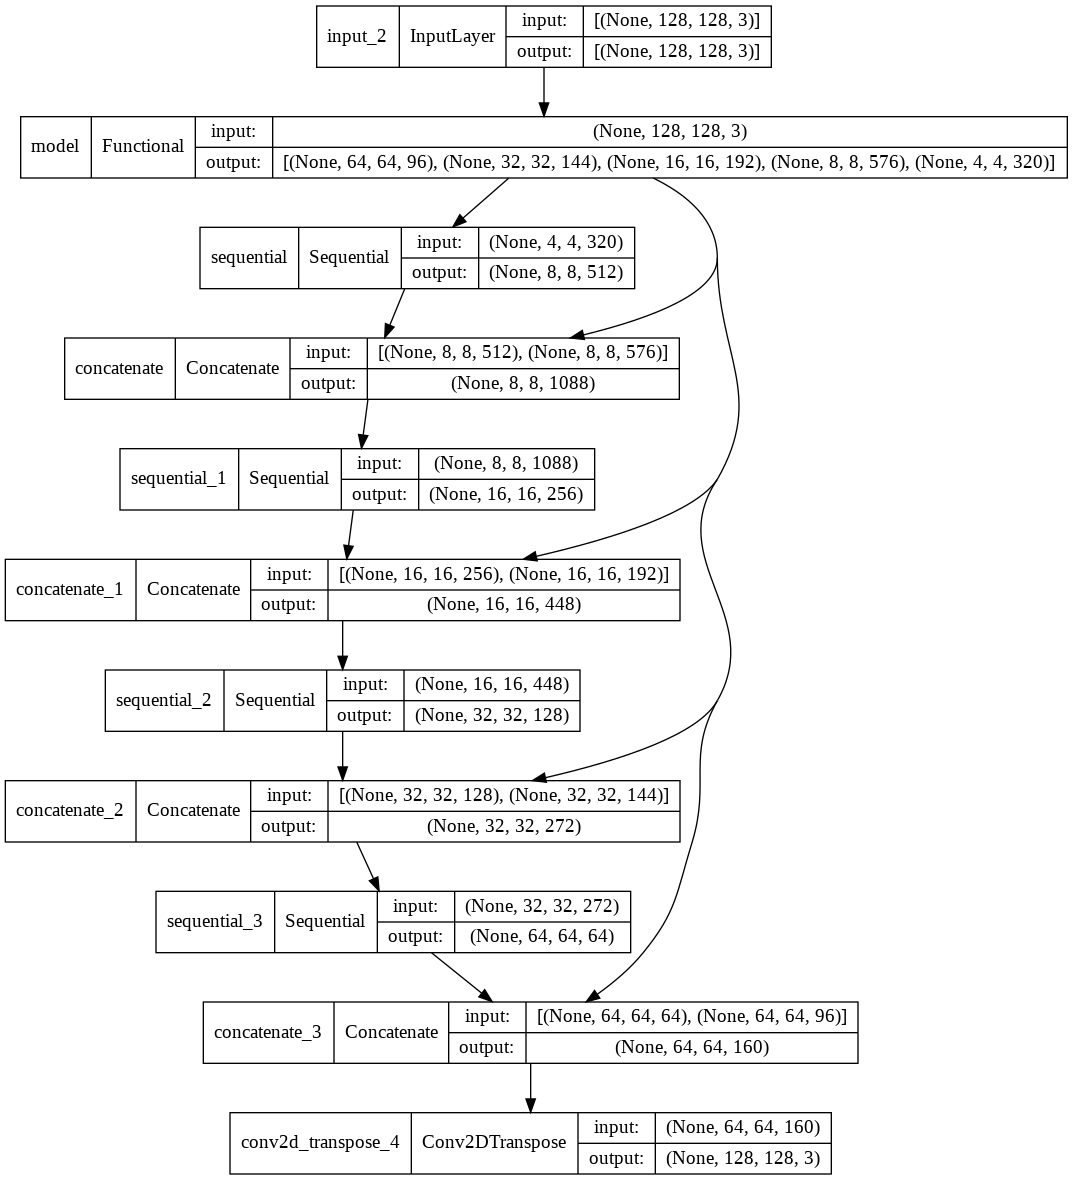

In [18]:
# Represent Modeling Architecture for Modified U-Net
tf.keras.utils.plot_model(model, show_shapes=True)

We can keep our architecture layout as reference if you ever wish to come back and understand what's going on with U-Nets more in detail.

However, at this point, we're ready to run our training algorithm. 

Let's start out by assessing how unlearned segmentation masks look... they probably won't look great.

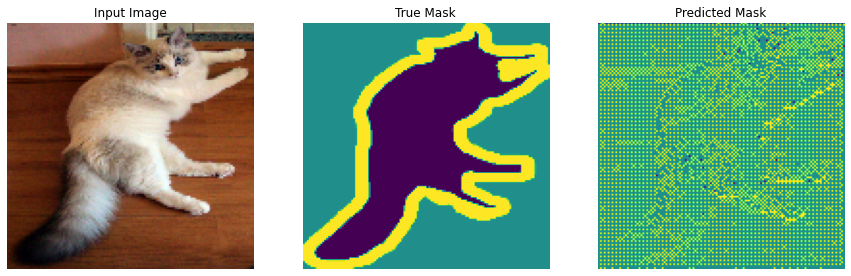

In [19]:
# Visualize True and Predicted Segmentation Masks Before Training
segmentation_visualizer()

And... they don't. 

Our unlearned predictive segmentation masks look like pseudo-random raw noise (not dissimilar to how our GANs generated images look prior to adversarial training).

Now it's our job to train our model such that the segmentations get better. 

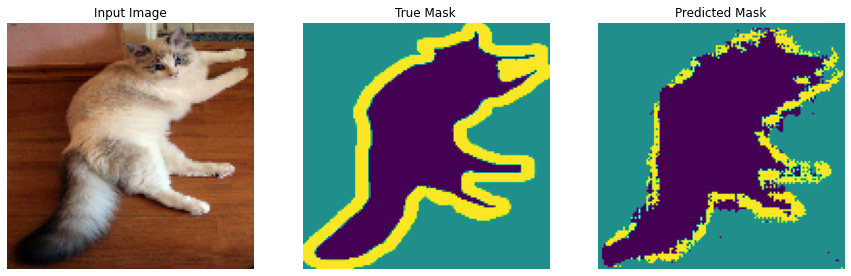


Sample Prediction after epoch 1

57/57 [==============================] - 358s 6s/step - loss: 0.5078 - accuracy: 0.7975 - val_loss: 0.5566 - val_accuracy: 0.8111
Epoch 2/20
 1/57 [..............................] - ETA: 2:34 - loss: 0.3176 - accuracy: 0.8688

In [ ]:
# Define Number of Epochs and Subsplit Segments for Validation Steps
EPOCHS, VALIDATION_SUBSPLITS = 20, 5
VALIDATION_STEPS = info.splits["test"].num_examples // BATCH_SIZE // VALIDATION_SUBSPLITS

# Train Modified U-Net (WARNING: HIGH COMPUTATIONAL EXPENSE!)
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayerCallback()])

The above code snippet will likely take a decently long time to run (unless you're training with a virtual GPU instance, which is encouraged) - whenever it does, you should be able to see that the predicted segmentation mask is decently well-fitted to the true image mask, albeit with some rough corners and edges. 

Still, that's definitely a strong success for our algorithm's first performance!

Now we can calculate our evaluation metrics across our model's history: more specifically, our model's loss estimates for both training and validation segments. 

In [ ]:
# Get Training & Validation Losses from Model History
training_loss = model_history.history["loss"]
validation_loss = model_history.history["val_loss"]

# Instantiate a Plotting Object for Chart Creation
plt.figure()

# Visualize Loss Metrics Across Chart
plt.plot(model_history.epoch, training_loss, "r", label="Training Loss")
plt.plot(model_history.epoch, validation_loss, "bo", label="Validation Loss")

# Configure Chart for Readability and Display
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.ylim([0, 1])
plt.legend()
plt.show()

---

### 📌 **REQUIRED CHALLENGE!** 📌

> Loss is an important evaluation metric to examine post-training, as is accuracy. 
> 
> But better is the evaluation visualization that can track both!
> 
> We've generated graphics and visualizations that chart loss and accuracy for both training and validation before; no reason we shouldn't do it now! 
> 
> **Your challenge is to modify the code in the programming cell below to visualize predictive accuracy for the training and validation segments, similarly to how loss is structurally evaluated in the cell above.**
> 
> Remember, no need to re-invent the wheel here; it's very likely that most of the same code and syntax can be replicated from the cell above to the cell below.

---

In [ ]:
# STUDENTS: Write some code to solve the aforementioned challenge here!

Now there's only one thing left to do: bask in your hard work by using your trained U-Net classifier to predict on brand new segmentation masks on original data.

In [ ]:
# Visualize True and Predicted Segmentation Masks After Training for Prediction
segmentation_visualizer(test_batches, 3)

Well done! You've successfully developed a working image segmentation algorithm that works with highly refined data! 

---
---

## 💠 **PART FIVE**: Conclusions 💠

Image segmentation - as you've no doubt experienced - can be a challenging yet rewarding algorithmic space to work within. 

At the bleeding edge of data science, there exist more and more algorithms attempting to become the next state-of-the-art engines for conducting tasks such as what you've just done.

It's worthwhile to reflect on your accomplishments by looking forward to new ways of improving on your work and continuing to refine your skills. 

---

### 📌 **REQUIRED CHALLENGE!** 📌

> You can always spend more time at the end of a major challenge thinking about new algorithms, hyperparameters, or design schema you could use to improve the project itself.
> 
> However, many also find it useful to tether what you learned from a mini-project to a research focus of your own.
> 
> **Your final challenge is to jot down some notes as to a unique application of image segmentation that you could see yourself building out from what you've learned from this challenge.**
> 
> Be specific when it comes to your domain-of-interest and target application; simply stating that you'd like to apply image segmentation to images isn't going to help you or anyone.
> 
> Rather, by identifying an imaging domain or problem space that motivates you, you can consolidate your learning and reinforce it with passion that keeps you in the field for the long game. 

---

Keep your responses to the final challenge in mind as you continue your journey forward into the field of artificial journey. 

This is, no doubt, not the last time we've seen advanced image learning at play, after all...

---
---
---